## Automated inversion for porosity in shallow reservoirs using a Pseudo-Transient Adjoint solver for nonlinear hydro-mechanical equations
by G. Reuber, L. Holbach, L. Raess

publsihed ???

Journal of Computational Physics

Cite as ???

### Electronic supplement 1
This is a FEniCS (https://fenicsproject.org/) developed Finite element code to discretize the forward, adjoint and gradient equation for the 1D nonlinear diffusion equation as described by equations (41-52) in the main paper.



In [1]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

# --------- Domain --------- #
nx = 64                                # number of elements
L = 20                                 # total physical length of the domain
Lmin = -L/2+((L/(nx-1))/2)
Lmax =  L/2-((L/(nx-1))/2)
mesh = IntervalMesh(nx, Lmin, Lmax)    # define mesh with FEniCS
degr = 2                               # interprete all FEniCS Expressions with degree 2

# --------- Function spaces --------- #
Vu = FiniteElement("CG", mesh.ufl_cell(), 1)     # Use a linear continous Lagrangian element for the solution
W = FunctionSpace(mesh, Vu)
Q2 = FunctionSpace(mesh,"CG", 1)                 # Dummy function space for plotting

# --------- Boundary conditions --------- #
def boundary_left(x, on_boundary):
    return (x[0] < Lmin + 1e-10) and on_boundary

def boundary_right(x, on_boundary):
    return (x[0] > Lmax - 1e-10) and on_boundary

bcl  = DirichletBC(W, Constant(1), boundary_left)
bcr  = DirichletBC(W, Constant(0.5), boundary_right)
bcs = [bcl,bcr]

# --------- Cost Function  --------- #
def cost(u, u_obs, nx): 
    misfit = 0
    for i in range(1,nx):     
        misfit = misfit + 0.5 *  (u.vector()[i]-u_obs.vector()[i])**2    # to compute the same as the matlab PTFD code
    return misfit

# --------- Forward solver Function  --------- #
def SolveForward(W, bcs, n, u, s):
    
    # Test and trial functions for nonlinear solver
    v  = TestFunction(W)
    du = TrialFunction(W) 
        
    F = (inner(grad(v),grad(u))*(u**n))*dx - (s*v)*dx     # note that this equation is nonlinear in u

    solve(F==0, u, bcs)

    print('     Forward solved ...')
    
    return u

# --------- Adjoint solver Function  --------- #
def SolveAdjoint(W, bcs, n, u, u_adj, u_obs):
    
    v = TestFunction(W) 
            
    F = (inner(grad(u_adj),(u**n*grad(v) + grad(u)*n*u**(n-1)*v)))*dx + ((u-u_obs)*v)*dx   # note that this equation is linear in u
    
    solve(F==0, u_adj, bcs)

    print('     Adjoint solved ...')
    
    return u_adj

# --------- Gradient evaluation Function  --------- #
def ComputeGradientn(W, n, u_adj, u):
    
    # Mass matrix in parameter space
    mtrial = TrialFunction(W)
    mtest  = TestFunction(W)
    
    Mvarf = inner(mtrial, mtest) * dx
    M     = assemble(Mvarf)
    gradi = Function(W)
        
    gradj =  ((inner(grad(u_adj),grad(u))*(u**n*ln(abs(u))))*mtest)*dx
    
    MG = assemble(gradj)
    solve(M, gradi.vector(), MG)
      
    grad_norm2 = gradi.vector().inner(MG)
    gradnorm   = np.sqrt(grad_norm2)
    
    print('     Gradient evaluated ...')
    
    return gradi, gradnorm

     Forward solved ...
     Forward solved ...
Initial misfit =  0.09421132671613441
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
0 misfit =  0.02460038141037586 / relative =  0.26111914849154605
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
1 misfit =  0.00693163334376809 / relative =  0.0735753712996061
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
2 misfit =  0.004683217109597119 / relative =  0.04970970341716971
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
3 misfit =  0.004103142551739616 / relative =  0.04355253975037082
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
4 misfit =  0.003551749493994648 / relative =  0.03769981400109488
     Adjoint solved ...
     Gradient evaluated ...
     Forward solved ...
5 misfit =  0.003034141570291444 / relative =  0.03220569835974748
     Adjoint solved ...
     Gradient evaluated ...
     Fo

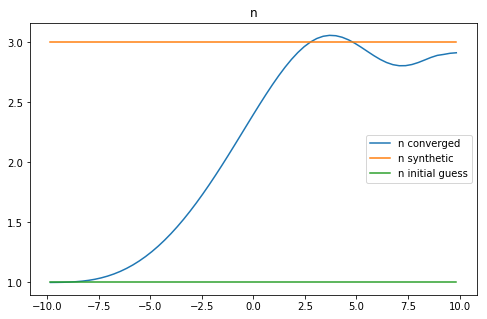

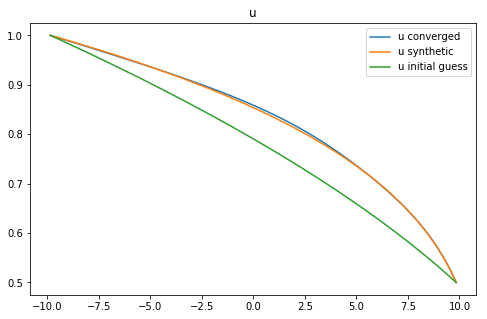

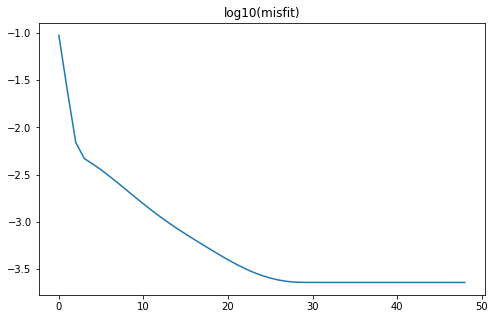

In [2]:
# --------- Initial conditions  --------- #
n = interpolate(Constant(3),W)
n_obs = n
s     = interpolate(Constant(0),W)

u_ini = Function(W)
u_ini.vector().set_local(np.random.rand(u_ini.vector().size())/10000 +1)  # to make Jacobian well posed
u_ini.vector().apply("")

# --------- Calculate synthetic data  --------- #
u       = SolveForward(W, bcs, n, u_ini, s)
u_obs   = interpolate(u, W)

# --------- Initial guess for inversion  --------- #
n      = interpolate(Constant(1),W)   # Homogeneous initial guess
#n      = interpolate(Expression('x[0]<0 ? 2:1',degree=degr),W)   # inhomogeneous initial guess underestimating
#n      = interpolate(Expression('x[0]<0 ? 5:1',degree=degr),W)   # inhomogeneous initial guess overestimating
n_plot = interpolate(n, Q2)
n_ig   = interpolate(n, Q2)

u      = SolveForward(W, bcs, n, u_ini, s)
u_ig   = interpolate(u, Q2)
    
misfit_ini = cost(u, u_obs, nx)
print('Initial misfit = ',misfit_ini)

# --------- Optimize n  --------- #
tol_rel = 1e-5
tol_abs = 1e-10
maxiter = 100
misfit_track = np.zeros([maxiter])

iter = 0
converged = False
while iter <  maxiter and not converged:

    # solve the adoint problem
    u_adj = SolveAdjoint(W, bcs, n, u, interpolate(Constant(0),W), u_obs)
    
    # evaluate the  gradient
    gradi, gradnorm = ComputeGradientn(W, n, u_adj, u)
    
    misfit = cost(u, u_obs, nx)
    misfit_track[iter] = misfit
    
    if iter == 0:
        gradnorm0 = gradnorm
        alpha     = 1e2      # initial step length
        np.savetxt('FEM_gradient',gradi.vector().get_local())

    # Backtracking linesearch
    it_backtrack = 0
    backtrack_converged = False
    it_backtrack_max = 10
    n_old = interpolate(n, Q2)    # store 'old' n
    for it_backtrack in range(it_backtrack_max):
        
        n.vector().axpy(-alpha, gradi.vector())   # update n temporarily
        
        u = SolveForward(W, bcs, n, u_ini, s)     # forward solve with current guess

        misfit_new = cost(u, u_obs, nx)           # check cost function decrease

        # check if backtracking converged
        if misfit_new < misfit: 
            misfit = misfit_new
            alpha *= 1.1
            backtrack_converged = True
            break
        else:
            n.assign(n_old)   # reset parameters
            alpha *= 0.1
            
    print(iter,'misfit = ',misfit_new,'/ relative = ',misfit_new/misfit_ini)
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break
    
    if gradnorm < tol_rel*gradnorm0  and iter > 0:
        converged = True
        misfit_new = cost(u, u_obs, nx) 
        print ("Steepest descent converged in ",iter,"  iterations")
        
    iter += 1
    
    if gradnorm0 < tol_abs:
        converged = True
        misfit_new = cost(u, u_obs, nx) 
        print ("Steepest descent converged in 1 iteration")
    
if not converged:
    misfit_new = cost(u, u_obs, nx)
    print ( "Steepest descent did not converge in ", maxiter, " iterations")


n_plot = interpolate(n, Q2)
plt.figure(figsize=(8,5))
plot(n_plot)
plot(n_obs)
plot(n_ig )
plt.legend(['n converged','n synthetic','n initial guess'], loc='best')
plt.title('n')
plt.show()

plt.figure(figsize=(8,5))
plot(u)
plot(u_obs)
plot(u_ig )
plt.title('u')
plt.legend(['u converged', 'u synthetic', 'u initial guess'], loc='best')
plt.show()

plt.figure(figsize=(8,5))
m_temp = misfit_track[0:iter]
plt.plot(np.log10(m_temp))
plt.title('log10(misfit)')
plt.show()